<a href="https://colab.research.google.com/github/swagatobag2000/digit-recognition-webapp.github.io/blob/main/Digit_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Sources

 - https://www.kaggle.com/code/puzzleleaf/introduction-to-cnn-keras-0-997-top-6/notebook
 - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
 - https://github.com/amarlearning/digit-recognition-opencv-cnn
 - https://github.com/maneprajakta/Digit_Recognition_Web_App
 - https://www.tensorflow.org/js/tutorials/conversion/import_keras

#### Required Packages Installation

In [43]:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 462 kB 11.1 MB/s 


#### Importing Libraries

In [11]:
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflowjs as tfjs
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import np_utils
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# K.set_image_dim_ordering('th')
%matplotlib inline
np.random.seed(2)
sns.set(style='white', context='notebook', palette='deep')

#### Loading Dataset (MNIST)

In [12]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

#### Pre-Preprocessing

 - Pperforming a grayscale normalization to reduce the effect of illumination's differences. Moreover the CNN converg faster on [0..1] data than on [0..255].
 - Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.
 - Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [13]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [14]:
if K.image_data_format() =='channels_first':
    input_shape = ((1,) + X_train[0].shape)
else:
    input_shape = (X_train[0].shape + (1,))

X_train = X_train.reshape((-1,) + input_shape)
X_test = X_test.reshape((-1,) + input_shape)

# # reshape to be [samples][width][height][channels]
# X_train = X_train.reshape((-1,) + X_train[0].shape + (1,)).astype('float32')
# X_test = X_test.reshape((-1,) + X_test[0].shape + (1,)).astype('float32')

In [15]:
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [16]:
# copying labels for further use
y_train_label = y_train.copy()
y_test_label = y_test.copy()
y_val_label = y_val.copy()

In [17]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)
num_classes = y_test.shape[1]

In [18]:
print(f"Size of Train Set: {len(X_train)}")
print(f"Size of Validation Set: {len(X_val)}")
print(f"Size of Test Set: {len(X_test)}")
print(f"Size of One Image in Train Set: {X_train[0].shape}")
print(f"Size of One Image in Validation Set: {X_val[0].shape}")
print(f"Size of One Image in Test Set: {X_test[0].shape}")
print(f"Classes Present: {num_classes}")
print(f"Labels Present: {np.unique(y_train_label)}")

Size of Train Set: 54000
Size of Validation Set: 6000
Size of Test Set: 10000
Size of One Image in Train Set: (28, 28, 1)
Size of One Image in Validation Set: (28, 28, 1)
Size of One Image in Test Set: (28, 28, 1)
Classes Present: 10
Labels Present: [0 1 2 3 4 5 6 7 8 9]


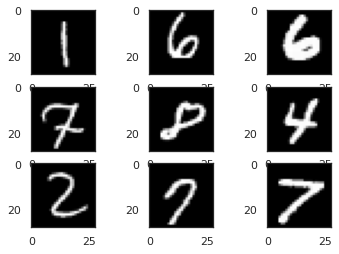

In [19]:
for i in range(0, 9): 
    plt.subplot(330 + 1 + i) 
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [20]:
for i in range(1, 10): 
  print(y_train_label[i-1],end = " ")
  if i % 3 == 0:
    print()

1 6 6 
7 8 4 
2 7 7 


#### Modelling


##### Model Defination
**[[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out**
 - The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image. The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

 - The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

 - Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

 - Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

 - 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

 - The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

 - In the end the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer (Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [21]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = input_shape))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D())
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

##### Optimizer and Annealer
 - Once our layers are added to the model, we need to set up:
  - a score function, 
  - a loss function
  - an optimisation algorithm.

 - We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

 - The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

 -  RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

 - The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [22]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [23]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                        

 - In order to make the optimizer converge faster and closest to the global minimum of the loss function, annealing method of the learning rate (LR) is used.

 - The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

 - Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

 - To keep the advantage of the fast computation time with a high LR, the LR has been decreased dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

 - With the ReduceLROnPlateau function from Keras.callbacks, it is set to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [25]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
# epochs = 1 
# Turn epochs to 30 to get 0.9967 accuracy
epochs = 30
batch_size = 86

##### Model Without Data Augmentation

In [27]:
import time
start = time.time()

In [28]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, workers=-1, use_multiprocessing=True, 
                    validation_data = (X_val, y_val), verbose = 2)

Epoch 1/30
628/628 - 23s - loss: 0.1961 - accuracy: 0.9375 - val_loss: 0.0476 - val_accuracy: 0.9857 - 23s/epoch - 36ms/step
Epoch 2/30
628/628 - 10s - loss: 0.0623 - accuracy: 0.9814 - val_loss: 0.0343 - val_accuracy: 0.9908 - 10s/epoch - 16ms/step
Epoch 3/30
628/628 - 10s - loss: 0.0482 - accuracy: 0.9855 - val_loss: 0.0362 - val_accuracy: 0.9913 - 10s/epoch - 16ms/step
Epoch 4/30
628/628 - 10s - loss: 0.0413 - accuracy: 0.9881 - val_loss: 0.0264 - val_accuracy: 0.9922 - 10s/epoch - 16ms/step
Epoch 5/30
628/628 - 10s - loss: 0.0379 - accuracy: 0.9894 - val_loss: 0.0277 - val_accuracy: 0.9915 - 10s/epoch - 16ms/step
Epoch 6/30
628/628 - 10s - loss: 0.0360 - accuracy: 0.9898 - val_loss: 0.0294 - val_accuracy: 0.9917 - 10s/epoch - 16ms/step
Epoch 7/30
628/628 - 11s - loss: 0.0345 - accuracy: 0.9901 - val_loss: 0.0329 - val_accuracy: 0.9913 - 11s/epoch - 18ms/step
Epoch 8/30
628/628 - 11s - loss: 0.0314 - accuracy: 0.9915 - val_loss: 0.0271 - val_accuracy: 0.9922 - 11s/epoch - 17ms/step


 - Without data augmentation, the accuracy is 98.87%

In [29]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time Elapsed: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Time Elapsed: 00:05:12.63


In [30]:
score ,acc = model.evaluate(X_test,y_test)
print("Score is :",score)
print("Accuracy :",acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.0263 - accuracy: 0.9930
Score is : 0.02633281610906124
Accuracy : 0.9929999709129333


##### Model With Data augmentation
 - In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

 - For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

 - Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

 - By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [31]:
# With data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='nearest')

datagen.fit(X_train)

For the data augmentation:

 - Randomly rotate some training images by 10 degrees
 - Randomly Zoom by 10% some training images
 - Randomly shift images horizontally by 10% of the width
 - Randomly shift images vertically by 10% of the height
 - No need to apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once the model is ready, we fit the training dataset .

In [32]:
import time
start = time.time()

In [33]:
# Fit the model
history2 = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, workers=-1, use_multiprocessing=True,
                              validation_data = (X_val,y_val), verbose = 2, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
627/627 - 31s - loss: 0.2099 - accuracy: 0.9486 - val_loss: 0.0680 - val_accuracy: 0.9872 - lr: 0.0010 - 31s/epoch - 49ms/step
Epoch 2/30
627/627 - 30s - loss: 0.1551 - accuracy: 0.9607 - val_loss: 0.0498 - val_accuracy: 0.9885 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 3/30
627/627 - 31s - loss: 0.1412 - accuracy: 0.9643 - val_loss: 0.0777 - val_accuracy: 0.9883 - lr: 0.0010 - 31s/epoch - 49ms/step
Epoch 4/30
627/627 - 31s - loss: 0.1332 - accuracy: 0.9676 - val_loss: 0.0577 - val_accuracy: 0.9890 - lr: 0.0010 - 31s/epoch - 49ms/step
Epoch 5/30
627/627 - 30s - loss: 0.1268 - accuracy: 0.9684 - val_loss: 0.0462 - val_accuracy: 0.9912 - lr: 0.0010 - 30s/epoch - 48ms/step
Epoch 6/30
627/627 - 30s - loss: 0.1245 - accuracy: 0.9695 - val_loss: 0.1185 - val_accuracy: 0.9852 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 7/30
627/627 - 30s - loss: 0.1272 - accuracy: 0.9686 - val_loss: 0.0763 - val_accuracy: 0.9892 - lr: 0.0010 - 30s/epoch - 49ms/step
Epoch 8/30

Epoch 8: ReduceLROnPla

 - Without data augmentation, the accuracy is 98.50%

In [34]:
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time Elapsed: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Time Elapsed: 00:15:11.24


In [35]:
score1 ,acc1 = model.evaluate(X_test,y_test)
print("Score is :",score1)
print("Accuracy :",acc1)

313/313 [==============================] - 2s 6ms/step - loss: 0.0462 - accuracy: 0.9930
Score is : 0.046188127249479294
Accuracy : 0.9929999709129333


#### Evaluate the model

##### Training and validation curves

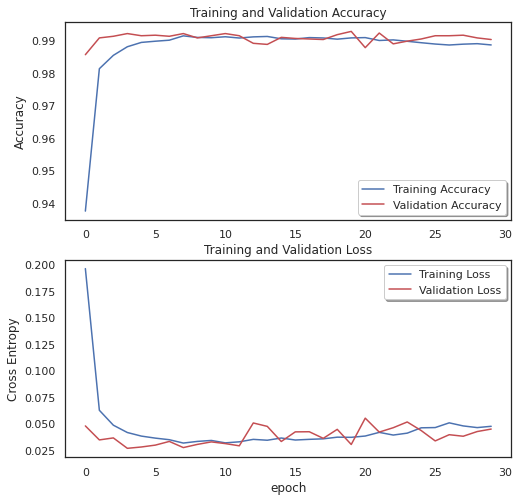

In [36]:
# Plot the loss and accuracy curves for training and validation -> Without Data Augmentation
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], color='b',label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], color='b',label='Training Loss')
plt.plot(history.history['val_loss'], color='r',label='Validation Loss')
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

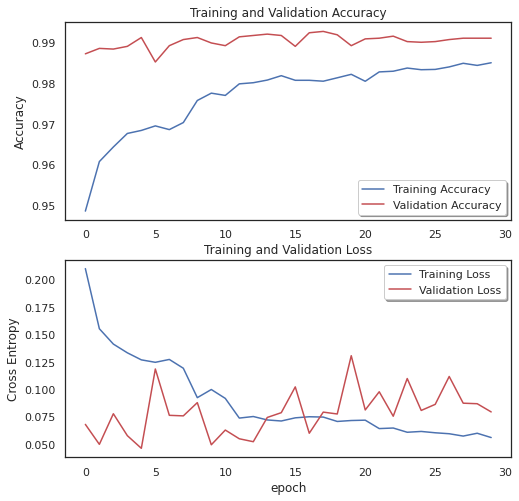

In [37]:
# Plot the loss and accuracy curves for training and validation -> Without Data Augmentation
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history2.history['accuracy'], color='b',label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history2.history['loss'], color='b',label='Training Loss')
plt.plot(history2.history['val_loss'], color='r',label='Validation Loss')
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

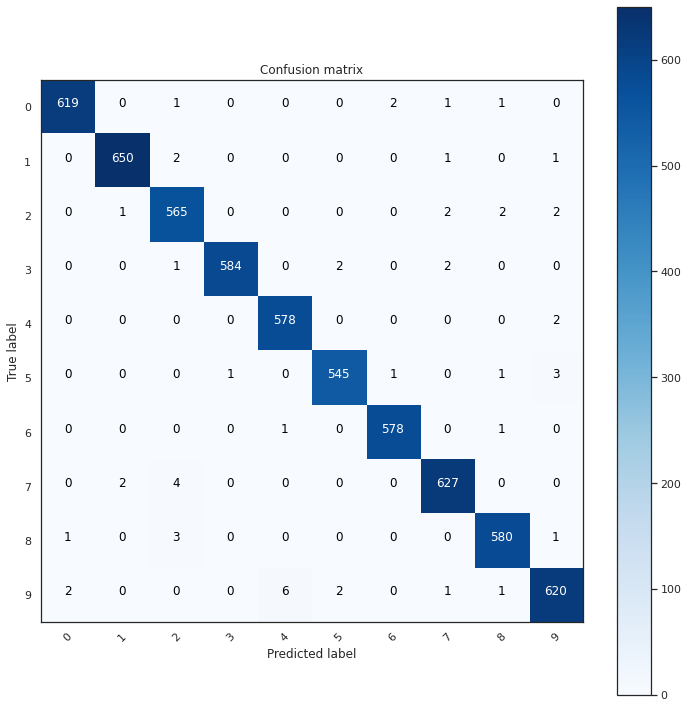

In [38]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_val) # Predict the values from the validation dataset
y_pred_classes = np.argmax(y_pred,axis = 1) # Convert predictions classes to one hot vectors 
y_true = np.argmax(y_val,axis = 1) # Convert validation observations to one hot vectors
confusion_mtx = confusion_matrix(y_true, y_pred_classes) # compute the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) # plot the confusion matrix

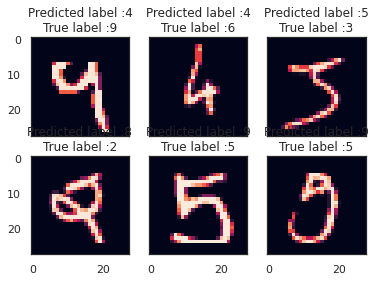

In [39]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1


Y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1)) # Predicted probabilities of the true values in the error set
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors # Difference between the probability of the predicted label and the true label
sorted_dela_errors = np.argsort(delta_pred_true_errors) # Sorted list of the delta prob errors
most_important_errors = sorted_dela_errors[-6:] # Top 6 errors 
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors) # Show the top 6 errors


#### Exporting Model

In [50]:
# Save whole model configuration + weights

# Keras models are usually saved via model.save(filepath), 
# which produces a single HDF5 (.h5) file containing both configuration + weights
model.save('digit_recognition.h5')
# model = load_model('digit_recognition.h5')  # -> to load the whole model

In [51]:
# Save Weights-only
model.save_weights('digit_recognition_weights.h5')
# model.load_weights('digit_recognition_weights.h5')  # -> to load the weights

In [52]:
# to save the architecture of a model (serialization), and not its weights or its training configuration
# Save model with .json extension
model_json = model.to_json()
with open("digit_recognition_config.json","w") as json_file:
    json_file.write(model_json)

In [53]:
# Save model with .tflite extension
model = tf.keras.models.load_model("digit_recognition.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('digit_recognition.tflite', 'wb') as tfliteFile:
  tfliteFile.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3528tbiq/assets


INFO:tensorflow:Assets written to: /tmp/tmp3528tbiq/assets


In [54]:
# Export the model directly to the TensorFlow.js Layers format

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,".")

In [ ]:
# Then load the model into TensorFlow.js by providing the URL to the model.json file:

# import * as tf from '@tensorflow/tfjs';
# const model = await tf.loadLayersModel('https://foo.bar/tfjs_artifacts/model.json');
# const prediction = model.predict(example);